## Install kaggle package and load its API key

In [1]:
!pip install kaggle

from googleapiclient.discovery import build
import io, os
from googleapiclient.http import MediaIoBaseDownload
from google.colab import auth

auth.authenticate_user()

drive_service = build('drive', 'v3')
# be sure your API key file json copied to your drive google
results = drive_service.files().list(q="name = 'kaggle.json'", fields="files(id)").execute()
kaggle_api_key = results.get('files', [])

filename = "/root/.kaggle/kaggle.json"
os.makedirs(os.path.dirname(filename), exist_ok=True)

request = drive_service.files().get_media(fileId=kaggle_api_key[0]['id'])
fh = io.FileIO(filename, 'wb')
downloader = MediaIoBaseDownload(fh, request)
done = False
while done is False:
    status, done = downloader.next_chunk()
    print("Download %d%%." %int(status.progress()*100))

os.chmod(filename, 600)

    100% |████████████████████████████████| 61kB 3.8MB/s 
    100% |████████████████████████████████| 235kB 6.7MB/s 
  Running setup.py bdist_wheel for kaggle ... - \ done
  Stored in directory: /root/.cache/pip/wheels/44/2c/df/22a6eeb780c36c28190faef6252b739fdc47145fd87a6642d4
  Running setup.py bdist_wheel for python-slugify ... - done
  Stored in directory: /root/.cache/pip/wheels/e3/65/da/2045deea3098ed7471eca0e2460cfbd3fdfe8c1d6fa6fcac92
Successfully built kaggle python-slugify
Download 100%.


In [0]:
# test kaggle command
# !kaggle competitions list

In [3]:
# download dataset from kaggle
!kaggle competitions download -c digit-recognizer -p /content/kaggle

 78% 57.0M/73.2M [00:00<00:00, 173MB/s]
100% 73.2M/73.2M [00:00<00:00, 199MB/s]
 84% 41.0M/48.8M [00:00<00:00, 149MB/s]
100% 48.8M/48.8M [00:00<00:00, 191MB/s]
  0% 0.00/235k [00:00<?, ?B/s]
100% 235k/235k [00:00<00:00, 107MB/s]


In [4]:
# import all of library used
import pandas as pd
import numpy as np
import matplotlib.pyplot as plt
import matplotlib
from sklearn.model_selection import train_test_split, KFold

from keras.models import Sequential
from keras.layers import Dense, Dropout, Flatten
# from keras.utils import np_utils  # fonctionality like get_dummies of pandas
from keras.layers.convolutional import Conv2D, MaxPooling2D
from keras import backend as K
K.set_image_dim_ordering('tf') # to change the shape of image is (samples, width, height, channels)
from keras.optimizers import RMSprop

# load data from keras
from keras.datasets import mnist

%matplotlib inline
plt.rcParams['figure.figsize'] = [10, 5]

Using TensorFlow backend.


In [5]:
import os
os.listdir("/content/kaggle")

['test.csv', 'train.csv', 'sample_submission.csv']

In [0]:
# load data set
path = "/content/kaggle"
train_kaggle = pd.read_csv(path + "/train.csv")
test_kaggle = pd.read_csv(path + "/test.csv")

In [10]:
print("train shape: ", train_kaggle.shape)
print("test shape: ", test_kaggle.shape)

train shape:  (42000, 785)
test shape:  (28000, 784)


## Train and test MNIST dataset using keras library

In [0]:
train_target_kaggle = train_kaggle.iloc[:, :1].values
train_kaggle = train_kaggle.iloc[:,1:].values.astype('float32')
test_kaggle = test_kaggle.iloc[:,:].values.astype('float32')

In [12]:
# standalize data
# this ways is normally used in the way of model of machine learning, like LightGBM, SVM...
'''
scale = np.max(train_kaggle)
train_kaggle /= scale
test_kaggle /= scale

mean = np.std(train_kaggle)
train_kaggle -= mean
test_kaggle -= mean
'''

'\nscale = np.max(train_kaggle)\ntrain_kaggle /= scale\ntest_kaggle /= scale\n\nmean = np.std(train_kaggle)\ntrain_kaggle -= mean\ntest_kaggle -= mean\n'

In [0]:
# in the case used by CNN, we normalize data by divide 255 (color)
train_kaggle = train_kaggle/255
test_kaggle = test_kaggle/255

In [14]:
# These 2 ways below to OneHotEncoding of the label that have multiple label, in this case: 0-9 (10 categories)
#target = np_utils.to_categorical(target)
print("Before:", train_target_kaggle.shape)
train_target_kaggle = pd.get_dummies(train_target_kaggle.ravel())
print("After:", train_target_kaggle.shape)

Before: (42000, 1)
After: (42000, 10)


In [0]:
# split data into training set and testing set
X_train, X_val, y_train, y_val = train_test_split(train_kaggle, train_target_kaggle, test_size=0.2, random_state=42)

In [16]:
X_train.shape, y_train.shape, X_val.shape, y_val.shape

((33600, 784), (33600, 10), (8400, 784), (8400, 10))

In [0]:
# a function to create input layer, hidden layer and output layer and then fully connected
def baseline_model():
    model = Sequential()
    model.add(Dense(784,input_dim=784, activation='relu'))
    model.add(Dense(10, activation='softmax'))
    
    model.compile(metrics=['accuracy'], loss='categorical_crossentropy', optimizer=RMSprop(lr=0.001))
    return model

In [18]:
# instance model
model = baseline_model()
model.summary()

_________________________________________________________________
Layer (type)                 Output Shape              Param #   
dense_1 (Dense)              (None, 784)               615440    
_________________________________________________________________
dense_2 (Dense)              (None, 10)                7850      
Total params: 623,290
Trainable params: 623,290
Non-trainable params: 0
_________________________________________________________________


In [19]:
# instance history to record all of variable of results
history = model.fit(X_train, y_train, validation_data=(X_val, y_val), epochs=20, batch_size=100, verbose=2)

Train on 33600 samples, validate on 8400 samples
Epoch 1/20
 - 2s - loss: 0.2869 - acc: 0.9139 - val_loss: 0.1485 - val_acc: 0.9562
Epoch 2/20
 - 2s - loss: 0.1159 - acc: 0.9655 - val_loss: 0.1229 - val_acc: 0.9640
Epoch 3/20
 - 2s - loss: 0.0736 - acc: 0.9781 - val_loss: 0.1090 - val_acc: 0.9685
Epoch 4/20
 - 2s - loss: 0.0521 - acc: 0.9836 - val_loss: 0.0851 - val_acc: 0.9739
Epoch 5/20
 - 2s - loss: 0.0368 - acc: 0.9888 - val_loss: 0.0881 - val_acc: 0.9745
Epoch 6/20
 - 2s - loss: 0.0261 - acc: 0.9921 - val_loss: 0.1031 - val_acc: 0.9713
Epoch 7/20
 - 2s - loss: 0.0198 - acc: 0.9938 - val_loss: 0.0888 - val_acc: 0.9768
Epoch 8/20
 - 2s - loss: 0.0142 - acc: 0.9962 - val_loss: 0.0923 - val_acc: 0.9779
Epoch 9/20
 - 2s - loss: 0.0106 - acc: 0.9969 - val_loss: 0.0918 - val_acc: 0.9780
Epoch 10/20
 - 2s - loss: 0.0078 - acc: 0.9975 - val_loss: 0.1053 - val_acc: 0.9760
Epoch 11/20
 - 2s - loss: 0.0056 - acc: 0.9988 - val_loss: 0.1062 - val_acc: 0.9771
Epoch 12/20
 - 2s - loss: 0.0043 - a

In [20]:
# show the model performance
scores = model.evaluate(X_val, y_val, verbose=0)
print("Baseline Error: %.2f%%" % (100-scores[1]*100))

Baseline Error: 2.00%


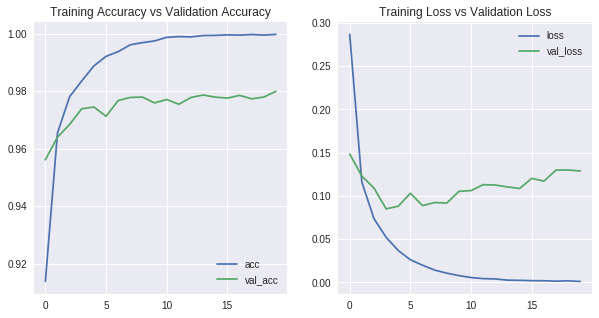

In [21]:
# plot the accuracy and loss in each process: training and validation
def plot_(history)
    acc = history.history['acc']
    val_acc = history.history['val_acc']

    loss = history.history['loss']
    val_loss = history.history['val_loss']

    f, [ax1, ax2] = plt.subplots(1,2)
    ax1.plot(range(len(acc)), acc, label="acc")
    ax1.plot(range(len(acc)), val_acc, label="val_acc")
    ax1.set_title("Training Accuracy vs Validation Accuracy")
    ax1.legend()

    ax2.plot(range(len(loss)), loss, label="loss")
    ax2.plot(range(len(loss)), val_loss, label="val_loss")
    ax2.set_title("Training Loss vs Validation Loss")
    ax2.legend()

plot_(history)



> This model have high variance and bias



## Simple Convolutional Neutral Network for MNIST

![LeNet-5](https://world4jason.gitbooks.io/research-log/content/deepLearning/CNN/img/lenet.png)

In [23]:
# rescale the data
X_train = X_train.reshape(-1,28,28,1)
X_val = X_val.reshape(-1,28,28,1)

X_train.shape, X_val.shape

((33600, 28, 28, 1), (8400, 28, 28, 1))

In [0]:
# using LeNet-5 to define the hidden layers
def model_baseline_CNN():
    model = Sequential()
    model.add(Conv2D(32, (3, 3), input_shape=(28, 28, 1), activation='relu'))
    model.add(MaxPooling2D(pool_size=(2, 2)))
    model.add(Conv2D(14, (3, 3), activation='relu'))
    model.add(MaxPooling2D(pool_size=(2, 2)))
    model.add(Dropout(0.2))
    model.add(Flatten())
    model.add(Dense(128, activation='relu'))
    model.add(Dense(50, activation='relu'))
    model.add(Dense(10, activation='softmax'))
    model.compile(metrics=['accuracy'], loss='categorical_crossentropy', optimizer=RMSprop(lr=0.001))
    return model

In [25]:
modelCNN = model_baseline_CNN()
modelCNN.summary()

_________________________________________________________________
Layer (type)                 Output Shape              Param #   
conv2d_1 (Conv2D)            (None, 26, 26, 32)        320       
_________________________________________________________________
max_pooling2d_1 (MaxPooling2 (None, 13, 13, 32)        0         
_________________________________________________________________
conv2d_2 (Conv2D)            (None, 11, 11, 14)        4046      
_________________________________________________________________
max_pooling2d_2 (MaxPooling2 (None, 5, 5, 14)          0         
_________________________________________________________________
dropout_1 (Dropout)          (None, 5, 5, 14)          0         
_________________________________________________________________
flatten_1 (Flatten)          (None, 350)               0         
_________________________________________________________________
dense_3 (Dense)              (None, 128)               44928     
__________

In [26]:
history = modelCNN.fit(X_train, y_train, validation_data=(X_val, y_val), epochs=10, batch_size=200, verbose=2)

Train on 33600 samples, validate on 8400 samples
Epoch 1/10
 - 3s - loss: 0.5326 - acc: 0.8363 - val_loss: 0.1638 - val_acc: 0.9532
Epoch 2/10
 - 2s - loss: 0.1589 - acc: 0.9513 - val_loss: 0.0963 - val_acc: 0.9698
Epoch 3/10
 - 2s - loss: 0.1088 - acc: 0.9655 - val_loss: 0.0911 - val_acc: 0.9710
Epoch 4/10
 - 2s - loss: 0.0824 - acc: 0.9740 - val_loss: 0.0642 - val_acc: 0.9804
Epoch 5/10
 - 2s - loss: 0.0698 - acc: 0.9779 - val_loss: 0.0553 - val_acc: 0.9825
Epoch 6/10
 - 2s - loss: 0.0620 - acc: 0.9808 - val_loss: 0.0456 - val_acc: 0.9871
Epoch 7/10
 - 2s - loss: 0.0538 - acc: 0.9831 - val_loss: 0.0507 - val_acc: 0.9838
Epoch 8/10
 - 2s - loss: 0.0488 - acc: 0.9840 - val_loss: 0.0428 - val_acc: 0.9871
Epoch 9/10
 - 2s - loss: 0.0444 - acc: 0.9858 - val_loss: 0.0452 - val_acc: 0.9850
Epoch 10/10
 - 2s - loss: 0.0438 - acc: 0.9852 - val_loss: 0.0358 - val_acc: 0.9880


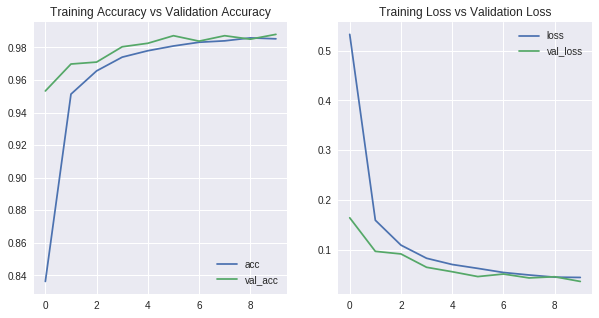

In [28]:
# plot the accuracy and loss in each process: training and validation  
plot_(history)



> We can see the gap between training line and validation line is nearly, it means that this model have low bias and variance





In [29]:
score = modelCNN.evaluate(X_val, y_val, verbose=0)
print("Baseline error %.2f%%" % (100-score[1]*100))

Baseline error 1.20%




> Model improved by 1,2% error, compared with 2% model early



## Combine data from Kaggle and Keras to train model



> We will import more and more data to see how model improve



In [34]:
# save kaggle dataset
X_train_kaggle, X_val_kaggle, y_train_kaggle, y_val_kaggle = X_train, X_val, y_train, y_val
X_train_kaggle.shape, X_val_kaggle.shape, y_train_kaggle.shape, y_val_kaggle.shape

((33600, 28, 28, 1), (8400, 28, 28, 1), (33600, 10), (8400, 10))

In [30]:
# load data from keras dataset
(X_train_keras, y_train_keras), (X_val_keras, y_val_keras) = mnist.load_data()
X_train_keras.shape, X_val_keras.shape, y_train_keras.shape, y_val_keras.shape

11493376/11490434 [==============================] - 1s 0us/step


((60000, 28, 28), (10000, 28, 28), (60000,), (10000,))

In [31]:
# rescale data
X_train_keras = X_train_keras.reshape(-1,28,28,1).astype('float32')
X_val_keras = X_val_keras.reshape(-1,28,28,1).astype('float32')
y_train_keras = pd.get_dummies(y_train_keras)
y_val_keras = pd.get_dummies(y_val_keras)
X_train_keras.shape, X_val_keras.shape, y_train_keras.shape, y_val_keras.shape

((60000, 28, 28, 1), (10000, 28, 28, 1), (60000, 10), (10000, 10))

In [0]:
#normalize data
X_train_keras /= 255
X_val_keras /= 255

In [57]:
X_train = np.concatenate((X_train_kaggle, X_train_keras), axis=0)
X_val = np.concatenate((X_val_kaggle, X_val_keras), axis=0)
y_train = np.concatenate((y_train_kaggle, y_train_keras), axis=0)
y_val = np.concatenate((y_val_kaggle, y_val_keras), axis=0)

X_train.shape, X_val.shape, y_train.shape, y_val.shape

((93600, 28, 28, 1), (18400, 28, 28, 1), (93600, 10), (18400, 10))

In [58]:
modelCNN = model_baseline_CNN()
modelCNN.summary()

_________________________________________________________________
Layer (type)                 Output Shape              Param #   
conv2d_25 (Conv2D)           (None, 26, 26, 32)        320       
_________________________________________________________________
max_pooling2d_25 (MaxPooling (None, 13, 13, 32)        0         
_________________________________________________________________
conv2d_26 (Conv2D)           (None, 11, 11, 14)        4046      
_________________________________________________________________
max_pooling2d_26 (MaxPooling (None, 5, 5, 14)          0         
_________________________________________________________________
dropout_13 (Dropout)         (None, 5, 5, 14)          0         
_________________________________________________________________
flatten_13 (Flatten)         (None, 350)               0         
_________________________________________________________________
dense_39 (Dense)             (None, 128)               44928     
__________

In [59]:
# we inscrease epochs and batch size to fit all of data
history = modelCNN.fit(X_train, y_train, validation_data=(X_val, y_val), epochs=36, batch_size=500, verbose=2)

Train on 93600 samples, validate on 18400 samples
Epoch 1/36
 - 4s - loss: 0.5048 - acc: 0.8407 - val_loss: 0.1857 - val_acc: 0.9391
Epoch 2/36
 - 3s - loss: 0.1400 - acc: 0.9563 - val_loss: 0.0805 - val_acc: 0.9755
Epoch 3/36
 - 3s - loss: 0.0882 - acc: 0.9719 - val_loss: 0.0663 - val_acc: 0.9786
Epoch 4/36
 - 3s - loss: 0.0669 - acc: 0.9793 - val_loss: 0.0988 - val_acc: 0.9653
Epoch 5/36
 - 3s - loss: 0.0534 - acc: 0.9828 - val_loss: 0.0480 - val_acc: 0.9852
Epoch 6/36
 - 3s - loss: 0.0460 - acc: 0.9856 - val_loss: 0.0456 - val_acc: 0.9845
Epoch 7/36
 - 3s - loss: 0.0394 - acc: 0.9868 - val_loss: 0.0317 - val_acc: 0.9892
Epoch 8/36
 - 3s - loss: 0.0366 - acc: 0.9884 - val_loss: 0.0216 - val_acc: 0.9926
Epoch 9/36
 - 3s - loss: 0.0315 - acc: 0.9900 - val_loss: 0.0289 - val_acc: 0.9908
Epoch 10/36
 - 3s - loss: 0.0300 - acc: 0.9901 - val_loss: 0.0190 - val_acc: 0.9939
Epoch 11/36
 - 3s - loss: 0.0265 - acc: 0.9915 - val_loss: 0.0203 - val_acc: 0.9935
Epoch 12/36
 - 3s - loss: 0.0246 - 

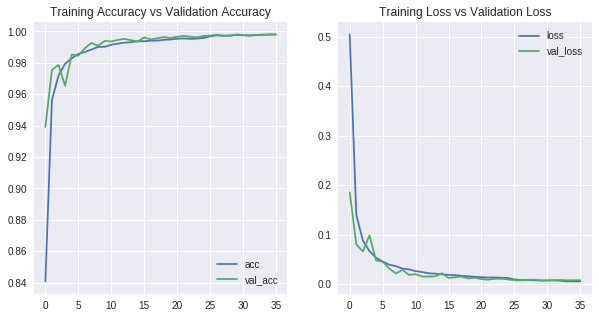

In [60]:
plot_(history)



> awesome, model is much more improved by getting more data



In [61]:
score = modelCNN.evaluate(X_val, y_val, verbose=0)
print("Baseline error %.2f%%" % (100-score[1]*100))

Baseline error 0.22%




> Good



## Adjust learning rate within fitting data

In [0]:
from keras.callbacks import ReduceLROnPlateau

learning_rate_reduction = ReduceLROnPlateau(monitor='val_acc', 
                                            patience=3, 
                                            verbose=1, 
                                            factor=0.5, 
                                            min_lr=0.0001)
history = modelCNN.fit(X_train, y_train, validation_data=(X_val, y_val), epochs=36, batch_size=500, 
                       verbose=2, callbacks=[learning_rate_reduction])

In [0]:
plot_(history)

In [0]:
score = modelCNN.evaluate(X_val, y_val, verbose=0)
print("Baseline error %.2f%%" % (100-score[1]*100))

## Submission results files to Kaggle competitions

In [0]:
# reshape the test set
test_kaggle = test_kaggle.reshape(-1,28,28,1).astype('float32')
pred_target = modelCNN.predict(test_kaggle)

In [0]:
pred_target = np.argmax(pred_target, axis=1)

In [0]:
submit = pd.read_csv(path+"/sample_submission.csv")
submit['Label'] = pred_target
submit.to_csv("results.csv", index=False)

In [0]:
import os, signal

os.kill(os.getpid(), signal.SIGKILL)